In [ ]:
!pip install --upgrade pip
!pip install --no-cache-dir --force-reinstall --upgrade jax[cpu]
# We run the examples with CPU. If GPU is prefered, substitute the above line into the following:
# !pip install --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

# Our implementation in an Anonymous github account
!pip install --no-cache-dir --force-reinstall -q git+https://github.com/0wh/neural-tangents_extension.git

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as np

from neural_tangents_extension import Infinite_time_inference, Finite_time_inference, nn, gaussian, imq, fem
import matplotlib.pyplot as plt

In [10]:
# the equation to be solved. Poisson's equation is defined as `d^2 y / d x^2 = source(x)`.
class Poissons_equation:
  def source(self, x):
    return -5.4*x
  def solution(self, x):
    return 1-0.9*x**3

equation = Poissons_equation()
test_x = np.linspace(0, 1, 200).reshape(-1, 1)

In [11]:
# do the infinite time inference for different choices of the sampling node density.
density = np.arange(4, 21)

# compare the performance of the neural-network-based solver, two RBF interpolation methods, and the Finite Element Method. 
experiment = Infinite_time_inference(model=nn, equation=equation, std=5/3)
for k in density:
    experiment.run(test_x, n_sample=k+1)

experiment_g = Infinite_time_inference(model=gaussian, equation=equation, c=0.31)
for k in density:
    experiment_g.run(test_x, n_sample=k+1)

experiment_i = Infinite_time_inference(model=imq, equation=equation, c=0.77)
for k in density:
    experiment_i.run(test_x, n_sample=k+1)

experiment_f = Infinite_time_inference(model=fem, equation=equation)
for k in density:
    experiment_f.run(test_x, n_sample=k+1)

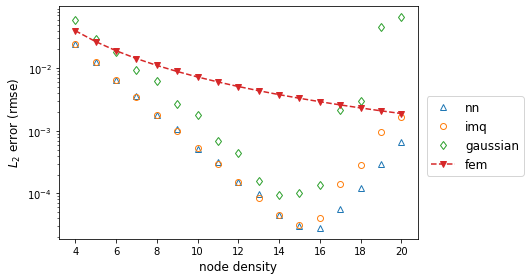

In [12]:
fig = plt.figure()
plt.xlabel('node density', fontsize=12)
plt.ylabel(r'$L_2$ error (rmse)', fontsize=12)

plt.semilogy(density, experiment.rmse, '^', fillstyle='none', label='nn')
plt.semilogy(density, experiment_i.rmse, 'o', fillstyle='none', label='imq')
plt.semilogy(density, experiment_g.rmse, 'd', fillstyle='none', label='gaussian')
plt.semilogy(density, experiment_f.rmse, '--v', label='fem')
fig.legend(fontsize=12, loc='center', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()

In [14]:
# do the infinite time inference for different choices of `std`.
shape = np.linspace(0.1, 0.8, 31)
experiment = Infinite_time_inference(model=nn, equation=equation)
for c in shape:
    experiment.run(test_x, n_sample=20, std=1/c, compute_cond=True)

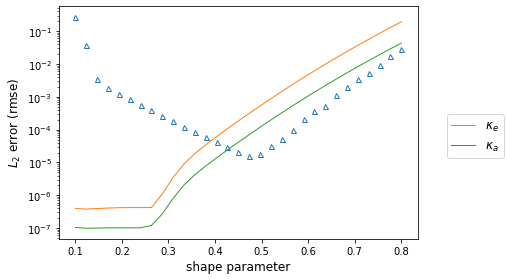

In [15]:
# the L_2 norm of the solution
u_l2 = np.sqrt(np.square(equation.solution(test_x)).mean()).item()

# estimate the round-off error by means of the Effective condition number and the Amotized condition number
estimate_effective = 2**-24*u_l2*np.array(experiment.cd_e)/np.sqrt(3)
estimate_amotized = 2**-24*u_l2*np.array(experiment.cd_a)/np.sqrt(3)

fig = plt.figure()
plt.xlabel('shape parameter', fontsize=12)
plt.ylabel('$L_2$ error (rmse)', fontsize=12)

plt.semilogy(shape, experiment.rmse, '^', markersize=5, fillstyle='none')
plt.semilogy(shape, estimate_effective, lw=1, label=r'$\kappa_e$')
plt.semilogy(shape, estimate_amotized, lw=1, label=r'$\kappa_a$')
fig.legend(fontsize=12, loc='center', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()

In [16]:
# compare the training dynamics with different choices of the initialization parameter `std`.
t = np.logspace(-3,7,101)
experiment1 = Finite_time_inference(model=nn, equation=equation)
experiment1.run(test_x, n_sample=80, t=t, std=11)

experiment2 = Finite_time_inference(model=nn, equation=equation)
experiment2.run(test_x, n_sample=80, t=t, std=16)

experiment3 = Finite_time_inference(model=nn, equation=equation)
experiment3.run(test_x, n_sample=80, t=t, std=8, compute_cov=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


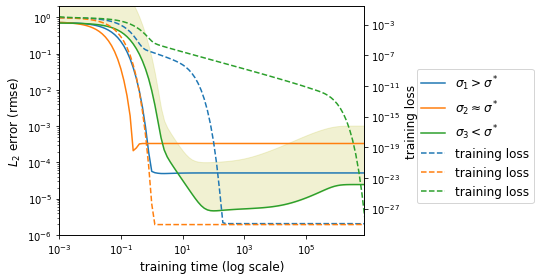

In [17]:
fig = plt.figure()
plt.xlabel(r'training time (log scale)', fontsize=12)
plt.ylabel(r'$L_2$ error (rmse)', fontsize=12)
plt.loglog(t, experiment1.rmse, label=r'$\sigma_1>\sigma^*$')
plt.loglog(t, experiment2.rmse, label=r'$\sigma_2\approx\sigma^*$')
plt.loglog(t, experiment3.rmse, label=r'$\sigma_3<\sigma^*$')
plt.fill_between(t, experiment3.rmse, np.array(experiment3.rmse)+np.array(experiment3.one_sigma), color='C8', alpha=0.2)
ax = plt.axes()
ax1 = ax.twinx()
ax1.set_ylabel('training loss', fontsize=12)
ax1.loglog(t, experiment1.loss, '--', c='C0', label='training loss')
ax1.loglog(t, experiment2.loss, '--', c='C1', label='training loss')
ax1.loglog(t, experiment3.loss, '--', c='C2', label='training loss')
ax.set_xlim(1e-3, 7.6e6)
ax.set_ylim(1e-6, 2)
fig.legend(fontsize=12, loc='center', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()